<a href="https://colab.research.google.com/github/YuHsin-Chen1221/Computational-Pathology/blob/main/Lung_Cancer_Histology_WSI_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/Kaggle_API/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download andrewmvd/lung-and-colon-cancer-histopathological-images

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
 97% 1.71G/1.76G [00:05<00:00, 76.1MB/s]
100% 1.76G/1.76G [00:05<00:00, 319MB/s] 


In [3]:
! unzip lung-and-colon-cancer-histopathological-images.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc10.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc100.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1000.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1001.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1002.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1003.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1004.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1005.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1006.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1007.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1008.jpeg  
  inflating: lung_colon_image_set/lung_image_sets

In [4]:
! pip install -q monai[all] cucim torchvision scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 109.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
 

In [1]:
import os
import random
from glob import glob
import shutil
from monai.data import Dataset, DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

# initialize transformers
from monai.transforms import (
    Compose, LoadImageD, EnsureChannelFirstD, ResizeD, ScaleIntensityD, ToTensorD
)

transforms = Compose([
    LoadImageD(keys="img", image_only=True), # Specify the key for the image path
    EnsureChannelFirstD(keys="img"),
    ResizeD(keys="img", spatial_size=(128, 128)),
    ScaleIntensityD(keys="img"),
    ToTensorD(keys=["img", "label"]) # Apply ToTensorD to both img and label keys
])

# data loading & splitting
def prepare_data(root_dir, val_split=0.2, seed=42):
    classes = ['lung_aca', 'lung_n', 'lung_scc']
    data = []

    for label_idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        image_paths = glob(os.path.join(class_dir, "*.jpeg"))
        for path in image_paths:
            data.append({"img": path, "label": label_idx})

    random.seed(seed)
    random.shuffle(data)
    split_idx = int(len(data) * (1 - val_split))

    return data[:split_idx], data[split_idx:]

# prepare dataloaders
def get_dataloaders(train_data, val_data, batch_size=32):
    train_ds = Dataset(data=train_data, transform=transforms)
    val_ds = Dataset(data=val_data, transform=transforms)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader

root_dir = "/content/lung_colon_image_set/lung_image_sets"
train_data, val_data = prepare_data(root_dir)
train_loader, val_loader = get_dataloaders(train_data, val_data)

In [17]:
for batch in train_loader:
    images = batch["img"]
    labels = batch["label"]
    print(images.shape, labels.shape)
    break

torch.Size([32, 3, 128, 128]) torch.Size([32])


In [19]:
! pip install timm matplotlib

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import timm

# Common classifier head for both models
class ClassifierHead(nn.Module):
    def __init__(self, in_features, num_classes=3):
        super().__init__()
        self.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.fc(x)

# ResNet50
def get_resnet50_model(num_classes=3):
    model = models.resnet50(pretrained=True)
    model.fc = ClassifierHead(model.fc.in_features, num_classes)
    return model

# EfficientNet-B3
def get_efficientnet_b3_model(num_classes=3):
    model = timm.create_model('efficientnet_b3a', pretrained=True)
    model.classifier = ClassifierHead(model.classifier.in_features, num_classes)
    return model

In [7]:
import matplotlib.pyplot as plt

def train(model, train_loader, val_loader, num_epochs=10, lr=0.001, device='cuda'):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch in train_loader:
            images = batch["img"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_train_loss = total_loss / len(train_loader)
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for batch in val_loader:
                images = batch["img"].to(device)
                labels = batch["label"].to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total

        # Logging
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history


In [8]:

def plot_metrics(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label='Train Loss')
    plt.plot(epochs, history["val_loss"], label='Val Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label='Train Acc')
    plt.plot(epochs, history["val_acc"], label='Val Acc')
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [9]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate(model, val_loader, class_names):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in val_loader:
            images = batch["img"].to(device)
            labels = batch["label"].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
Mapping deprecated model name efficientnet_b3a to current efficientnet_b3.


Training ResNet50
Epoch [1/10], Train Loss: 0.1896, Train Acc: 0.9237, Val Loss: 0.1258, Val Acc: 0.9487
Epoch [2/10], Train Loss: 0.1019, Train Acc: 0.9628, Val Loss: 0.3781, Val Acc: 0.8737
Epoch [3/10], Train Loss: 0.0757, Train Acc: 0.9730, Val Loss: 0.0787, Val Acc: 0.9683
Epoch [4/10], Train Loss: 0.0623, Train Acc: 0.9782, Val Loss: 0.1235, Val Acc: 0.9543
Epoch [5/10], Train Loss: 0.0465, Train Acc: 0.9823, Val Loss: 0.1868, Val Acc: 0.9260
Epoch [6/10], Train Loss: 0.0497, Train Acc: 0.9827, Val Loss: 0.0765, Val Acc: 0.9653
Epoch [7/10], Train Loss: 0.0346, Train Acc: 0.9872, Val Loss: 0.0390, Val Acc: 0.9843
Epoch [8/10], Train Loss: 0.0316, Train Acc: 0.9882, Val Loss: 0.0641, Val Acc: 0.9787
Epoch [9/10], Train Loss: 0.0302, Train Acc: 0.9903, Val Loss: 0.2028, Val Acc: 0.9407
Epoch [10/10], Train Loss: 0.0204, Train Acc: 0.9936, Val Loss: 0.0341, Val Acc: 0.9867


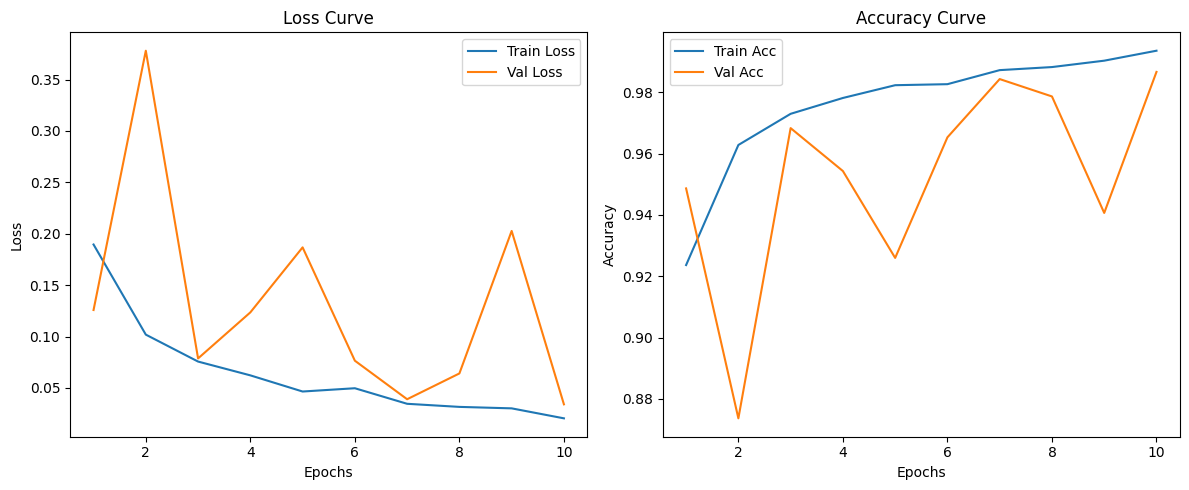

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d8790791b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^Exception ignored in: ^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7d8790791b20>
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^    Exception ignored in: ^if w.is

              precision    recall  f1-score   support

    lung_aca       0.98      0.98      0.98       971
      lung_n       1.00      1.00      1.00      1023
    lung_scc       0.98      0.98      0.98      1006

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



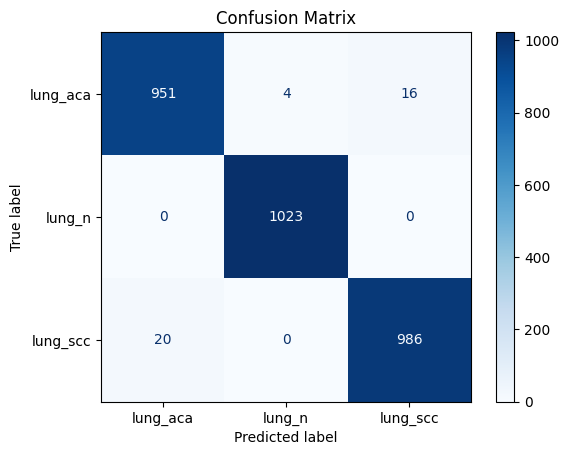

Training EfficientNet-B3
Epoch [1/10], Train Loss: 0.1114, Train Acc: 0.9613, Val Loss: 0.3280, Val Acc: 0.9820
Epoch [2/10], Train Loss: 0.0362, Train Acc: 0.9877, Val Loss: 0.0202, Val Acc: 0.9930
Epoch [3/10], Train Loss: 0.0161, Train Acc: 0.9947, Val Loss: 0.0034, Val Acc: 0.9993
Epoch [4/10], Train Loss: 0.0343, Train Acc: 0.9894, Val Loss: 0.0368, Val Acc: 0.9950
Epoch [5/10], Train Loss: 0.0215, Train Acc: 0.9940, Val Loss: 0.1176, Val Acc: 0.9953
Epoch [6/10], Train Loss: 0.0028, Train Acc: 0.9992, Val Loss: 0.1062, Val Acc: 0.9893
Epoch [7/10], Train Loss: 0.0060, Train Acc: 0.9984, Val Loss: 0.0477, Val Acc: 0.9953
Epoch [8/10], Train Loss: 0.0239, Train Acc: 0.9927, Val Loss: 0.4721, Val Acc: 0.9917
Epoch [9/10], Train Loss: 0.0269, Train Acc: 0.9908, Val Loss: 0.0103, Val Acc: 0.9970
Epoch [10/10], Train Loss: 0.0049, Train Acc: 0.9985, Val Loss: 0.0029, Val Acc: 0.9990


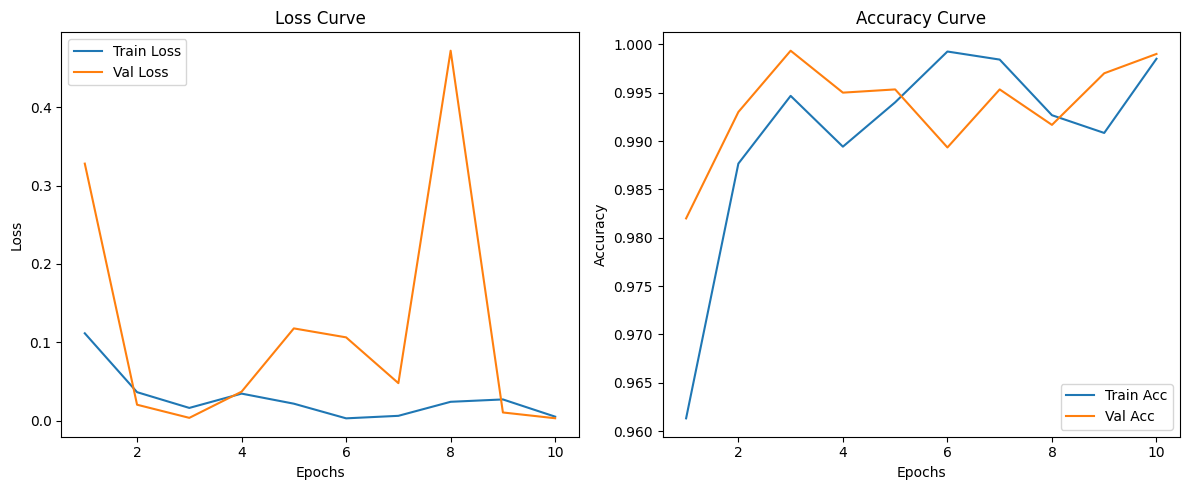

              precision    recall  f1-score   support

    lung_aca       1.00      1.00      1.00       971
      lung_n       1.00      1.00      1.00      1023
    lung_scc       1.00      1.00      1.00      1006

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



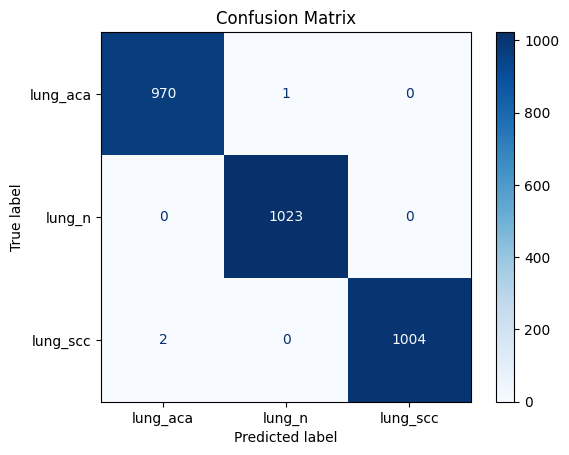

In [11]:
# performance comparing

res_model = get_resnet50_model()
efficient_model = get_efficientnet_b3_model()

print("Training ResNet50")
res_history = train(res_model, train_loader, val_loader)
plot_metrics(res_history)
evaluate(res_model, val_loader, class_names=["lung_aca", "lung_n", "lung_scc"])

print("Training EfficientNet-B3")
efficient_history = train(efficient_model, train_loader, val_loader)
plot_metrics(efficient_history)
evaluate(efficient_model, val_loader, class_names=["lung_aca", "lung_n", "lung_scc"])

Validation Predictions: ResNet50


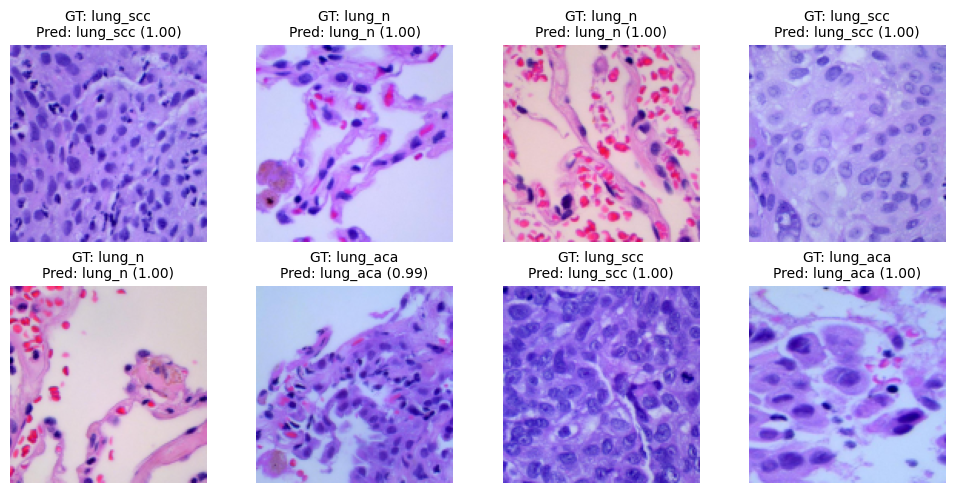

Validation Predictions: EfficientNet-b3


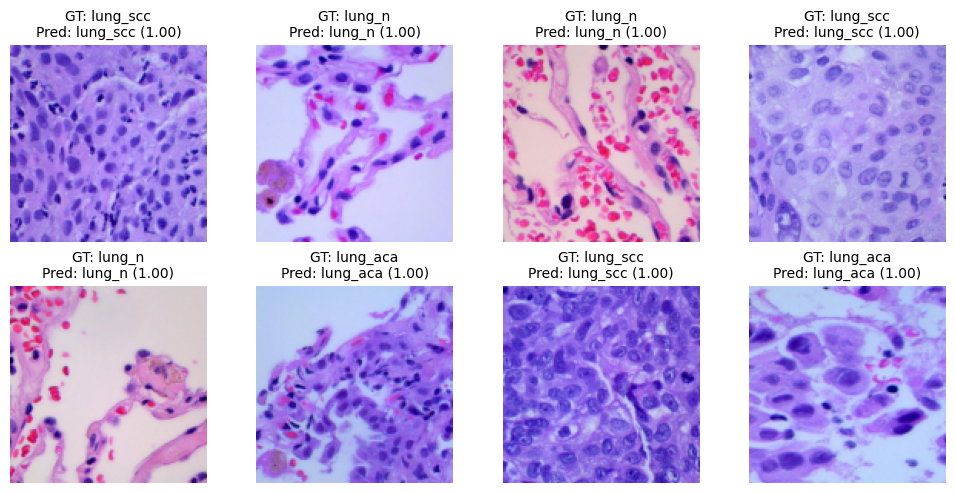

In [16]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Class labels
class_names = ['lung_aca', 'lung_n', 'lung_scc']

def visualize_val_predictions(model, val_loader, device, num_samples=8):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(10, 5))

    with torch.no_grad():
        for batch in val_loader:
            images = batch["img"].to(device)
            labels = batch["label"].to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            for i in range(images.size(0)):
                if images_shown >= num_samples:
                    break

                img_np = images[i].cpu().numpy().transpose(1, 2, 0).squeeze()  # (H, W)
                true_label = class_names[labels[i].item()]
                pred_label = class_names[preds[i].item()]
                confidence = probs[i][preds[i]].item()

                plt.subplot(2, num_samples//2, images_shown + 1)
                plt.imshow(img_np, cmap='gray')
                plt.title(f"GT: {true_label}\nPred: {pred_label} ({confidence:.2f})", fontsize=10)
                plt.axis('off')

                images_shown += 1

            if images_shown >= num_samples:
                break

    plt.tight_layout()
    plt.show()

print("Validation Predictions: ResNet50")
visualize_val_predictions(res_model, val_loader, device)
print("Validation Predictions: EfficientNet-b3")
visualize_val_predictions(efficient_model, val_loader, device)
